In [1]:
# Projeto de Aprendizado de Máquina
# Aprendizado de máquina no auxílio para diagnósticos médicos: Diferencial entre COVID-19 e Pneumonia por Raio-X de Tórax

# Caio Bohlhalter de Souza
# Jeferson Patrick Dietrich Filho

# Projeto orientado pela Profª Verônica Oliveira de Carvalho

# Proposta de projeto:
# https://docs.google.com/document/d/1uEbctbl0NRMt0JqrIm3f5ihobDgLaR9f0iVCDjmQZsY/edit?usp=sharing

In [2]:
# Orientações para importar as bibliotecas
# O código do projeto foi feito com o Jupyter da Anaconda.
# Para instalar alguns módulos/bibliotecas será necessário rodar os seguintes códigos no Anaconda Prompt

# splitfolders
# pip install split-folders

# Para outras bibliotecas que não tiver o módulo/biblioteca instalado, deve-se fazer o mesmo

In [3]:
# Bibliotecas de sistema
import os
from PIL import Image

# Bibliotecas para manipulação de dados
import numpy as np
import pandas as pd
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy.stats import mode

print ('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


In [4]:
# Antes de tudo, vamos verificar se as imagens foram importadas corretamente.
# Para isso, vamos mostrar a imagem com suas dimensões (em pixels) e modelo, caso tenham.
# Isso será feito para todas as classes: COVID, Normal, Pneumonia Viral, Opacidade Pulmonar

Dimensões: (299, 299)


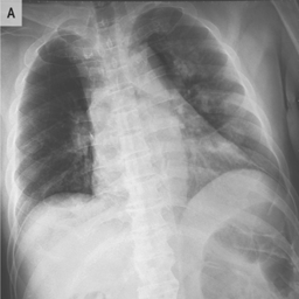

In [5]:
diretorio_imagem_covid = "./COVID-19_Radiography_Dataset-imagens/COVID/COVID-2.png"
imagem_covid = Image.open(diretorio_imagem_covid)
print("Dimensões:", imagem_covid.size)
imagem_covid

Dimensões: (299, 299)


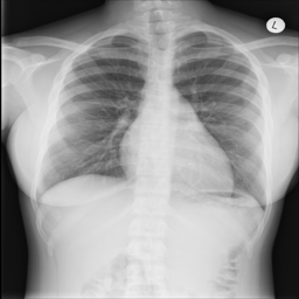

In [6]:
diretorio_imagem_normal = "./COVID-19_Radiography_Dataset-imagens/NORMAL//NORMAL-2.png"
imagem_normal = Image.open(diretorio_imagem_normal)
print("Dimensões:", imagem_normal.size)
imagem_normal

Dimensões: (299, 299)
Modelo: L


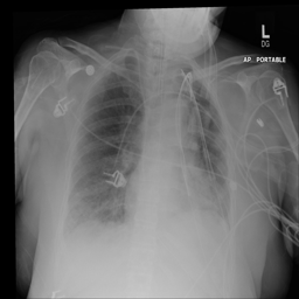

In [7]:
diretorio_imagem_opacidade = "./COVID-19_Radiography_Dataset-imagens/Lung_Opacity/Lung_Opacity-2.png"
imagem_opacidade = Image.open(diretorio_imagem_opacidade)
print("Dimensões:", imagem_opacidade.size)
print("Modelo:", imagem_opacidade.mode)
imagem_opacidade

Dimensões: (299, 299)
Modelo: L


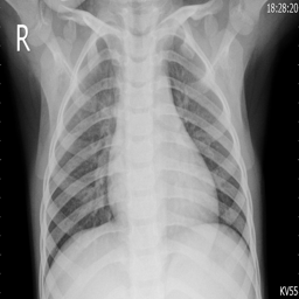

In [8]:
dir_imagem_pneumonia = "./COVID-19_Radiography_Dataset-imagens/Viral Pneumonia/Viral Pneumonia-2.png"
imagem_pneumonia = Image.open(dir_imagem_pneumonia)
print("Dimensões:", imagem_pneumonia.size)
print("Modelo:", imagem_pneumonia.mode)
imagem_pneumonia

In [9]:
# Definindo o diretório com todas as classes
diretorio_input = "./COVID-19_Radiography_Dataset-imagens/"
output = "roentgen-v2"

splitfolders.ratio(diretorio_input, output=output, seed=42, ratio=(0.6, 0.2, 0.2), group_prefix=None)

Copying files: 21025 files [00:36, 581.14 files/s]


In [10]:
# Afim de organizar melhor os resultados, será criados outros diretórios
diretorio_treino = 'roentgen-v2/train'
diretorio_validacao = 'roentgen-v2/val'
diretorio_teste = 'roentgen-v2/test'

In [11]:
# De início, será necessário, além de carregar as imagens, fazer o pré-processamento delas.
# Isso facilita o aprendizado, pois torna a imagem mais limpa e leve para ser processada.

# Para isso, utilizamos o DataGenerator do Keras,
# que normaliza as imagens reescanlando elas para pixels entre [0,1] e outras possíveis transformações.
    # ImageDataGenerator: Geração de lote de dados de imagens; Apenas redimensionamos as imagens
    # O método "flow_from_directory" espera que as imagens estejam organizadas em subpastas conforme as classes, que já estão divididas.
    # Classes: O algortimo define por conta própria quais serão as classes, mas deve conter, ao menos, as abaixo:
        # Normal
        # Lung_Opacity
        # Viral Pneumonia
        # COVID
    #Utilizamos o Sparse para receber valores inteiros

data_generator_treino = ImageDataGenerator(rescale=1./255)
data_generator_validacao = ImageDataGenerator(rescale=1./255)
data_generator_teste = ImageDataGenerator(rescale=1./255)

treino_generator = data_generator_treino.flow_from_directory(
    diretorio_treino,
    target_size=(299, 299),
    batch_size=16,
    class_mode='sparse'
)

validacao_generator = data_generator_validacao.flow_from_directory(
    diretorio_validacao,
    target_size=(299, 299),
    batch_size=16,
    class_mode='sparse'
)

teste_generator = data_generator_teste.flow_from_directory(
    diretorio_teste,
    target_size=(299, 299),
    batch_size=16,
    class_mode='sparse'
)

Found 12614 images belonging to 4 classes.
Found 4204 images belonging to 4 classes.
Found 4207 images belonging to 4 classes.


In [12]:
# Alguns dos conceitos utilizados nesse modelo já foram utilizados/explicados no modelo U2-Net
# No código desse modelo estará mais detalhado conceitos como convolução de imagem, pooling, etc...

In [13]:
modelo_base = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
modelo = Model(inputs=modelo_base.input, outputs=modelo_base.output)

In [14]:
#Foi adicionado o numero da batch processada para se ter um melhor controle
def extract_features(generator):
    features = []
    labels = []
    total_samples = generator.samples
    batch_size = generator.batch_size
    num_batches = int(np.ceil(total_samples / batch_size))
    
    print(f"Extraindo features de {total_samples} amostras em {num_batches} batches...")

    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = modelo.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        
        print(f"Processado batch {i+1}/{num_batches}")

        if (i + 1) * batch_size >= total_samples:
            break

    return np.vstack(features), np.concatenate(labels)

In [15]:
# Extraindo features de treino, validação e teste
train_features, train_labels = extract_features(treino_generator)
val_features, val_labels = extract_features(validacao_generator)
test_features, test_labels = extract_features(teste_generator)

Extraindo features de 12614 amostras em 789 batches...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 1/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 2/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 3/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Processado batch 4/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 5/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 6/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 7/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 8/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 9/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 10/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 11/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 12/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 13/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 14/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 15/789
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processado batch 1

In [16]:
# Redimensionando as features para 2D
train_features = train_features.reshape((train_features.shape[0], -1))
val_features = val_features.reshape((val_features.shape[0], -1))
test_features = test_features.reshape((test_features.shape[0], -1))

In [17]:
# Aplicando K-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(train_features)

C:\Users\caiob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [18]:
def map_clusters_to_labels(features, labels, kmeans):
    predictions = kmeans.predict(features)
    labels_map = {}
    for i in range(kmeans.n_clusters):
        mask = (predictions == i)
        if np.sum(mask) > 0:  # Verifica se há elementos no cluster
            labels_map[i] = mode(labels[mask])[0]
        else:
            labels_map[i] = -1  # Ou algum valor padrão, se necessário
    return labels_map

In [19]:
# Mapeando clusters para labels reais usando os dados de validação
labels_map = map_clusters_to_labels(val_features, val_labels, kmeans)

# Convertendo predições de clusters para labels reais
def map_predictions(predictions, labels_map):
    return np.vectorize(labels_map.get)(predictions)

In [20]:
# Avaliando com os dados de teste
test_preds = kmeans.predict(test_features)
test_preds_mapped = map_predictions(test_preds, labels_map)
test_accuracy = accuracy_score(test_labels, test_preds_mapped)

In [21]:
# Avaliando com os dados de validação
val_preds = kmeans.predict(val_features)
val_preds_mapped = map_predictions(val_preds, labels_map)
val_accuracy = accuracy_score(val_labels, val_preds_mapped)

In [22]:
# Calculando métricas de avaliação
print(confusion_matrix(test_labels, test_preds_mapped))
print(classification_report(test_labels, test_preds_mapped))

[[   0  608  116    0]
 [   0 1045  158    0]
 [   0  480 1559    0]
 [   0   76  165    0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       724
         1.0       0.47      0.87      0.61      1203
         2.0       0.78      0.76      0.77      2039
         3.0       0.00      0.00      0.00       241

    accuracy                           0.62      4207
   macro avg       0.31      0.41      0.35      4207
weighted avg       0.51      0.62      0.55      4207



C:\Users\caiob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\caiob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\caiob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\caiob\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


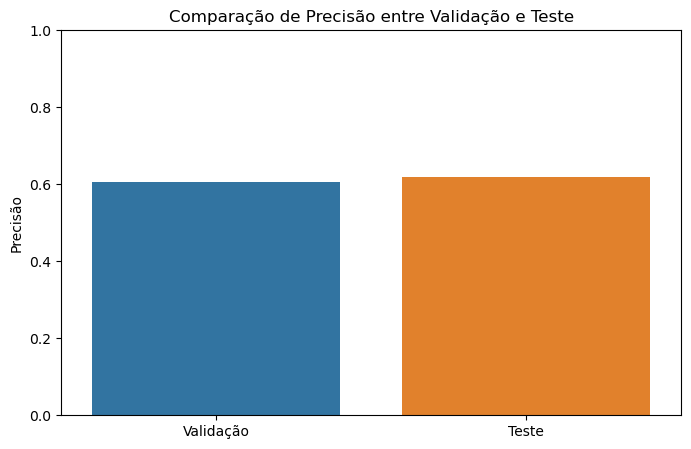

In [23]:
accuracies = [val_accuracy, test_accuracy]
labels = ['Validação', 'Teste']

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=accuracies)
plt.ylim(0, 1)
plt.ylabel('Precisão')
plt.title('Comparação de Precisão entre Validação e Teste')
plt.show()

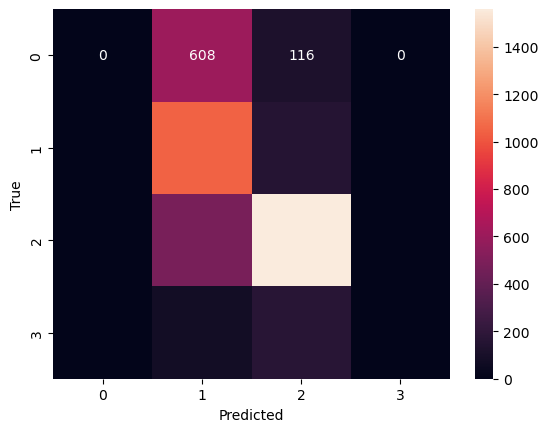

In [24]:
# Visualizando a matriz de confusão
conf_matrix = confusion_matrix(test_labels, test_preds_mapped)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()